In [1]:
import click
import os
import numpy as np
import pandas as pd
import random
import time
from datetime import datetime
import tensorflow as tf
import tensorflow.contrib.slim as slim
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from data_model import StockDataSet
from model_rnn import LstmRNN
import matplotlib.pyplot as plt

#All config parameters of Tensorflow
flags = tf.app.flags
flags.DEFINE_integer("stock_count", 100, "Stock count [100]")
flags.DEFINE_integer("input_size", 1, "Input size [1]")
flags.DEFINE_integer("num_steps", 30, "Num of steps [30]")
flags.DEFINE_integer("num_layers", 1, "Num of layer [1]")
flags.DEFINE_integer("lstm_size", 128, "Size of one LSTM cell [128]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_float("keep_prob", 0.8, "Keep probability of dropout layer. [0.8]")
flags.DEFINE_float("init_learning_rate", 0.001, "Initial learning rate at early stage. [0.001]")
flags.DEFINE_float("learning_rate_decay", 0.99, "Decay rate of learning rate. [0.99]")
flags.DEFINE_integer("init_epoch", 5, "Num. of epoches considered as early stage. [5]")
flags.DEFINE_integer("max_epoch", 50, "Total training epoches. [50]")
flags.DEFINE_integer("embed_size", None, "If provided, use embedding vector of this size. [None]")
flags.DEFINE_string("stock_symbol", "WIG", "Target stock symbol [None]")
flags.DEFINE_integer("sample_size", 4, "Number of stocks to plot during training. [4]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_float("test_ratio", 0.05, "Test ratio. [0.05]")
FLAGS = flags.FLAGS

DATA_DIR = "stock_data"
NEW_DATA_DIR = "new_stock_data"
MODEL_DIR = "models"
BOSSA_PL_STOCK_DATA_URL = "http://bossa.pl/pub/metastock/mstock/mstall.zip"
WIG_PATH = os.path.join(DATA_DIR, "WIG.mst")



In [2]:
#Download newest stock data if not downloaded today and unzip
today = datetime.now()
today_dir = os.path.join(NEW_DATA_DIR, today.strftime('%Y%m%d'))

if(not os.path.exists(today_dir)): 
   os.makedirs(today_dir)
   resp = urlopen(BOSSA_PL_STOCK_DATA_URL)
   zipfile = ZipFile(BytesIO(resp.read()))
   zipfile.extractall(today_dir)

KeyboardInterrupt: 

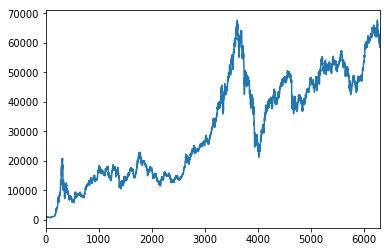

In [2]:
df_wig = pd.read_csv(WIG_PATH)

df_wig['<OPEN>'].plot()

In [4]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True

In [3]:

with tf.Session(config=run_config) as sess:
   rnn_model = LstmRNN(
      sess,
      FLAGS.stock_count,
      lstm_size=FLAGS.lstm_size,
      num_layers=FLAGS.num_layers,
      num_steps=FLAGS.num_steps,
      input_size=FLAGS.input_size,
      embed_size=FLAGS.embed_size,
   )
   stock_data_list =  [
      StockDataSet(
         FLAGS.stock_symbol,
         input_size=FLAGS.input_size,
         num_steps=FLAGS.num_steps,
         test_ratio=FLAGS.test_ratio)
    ]
   #rnn_model.train(stock_data_list, FLAGS)

   #saver = tf.train.Saver()
   #saver.save(sess, os.path.join(MODEL_DIR,graph_name, '.ckpt'))


inputs.shape:(?, 30, 1)
inputs_with_embed.shape:(?, 30, 1)


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/stock_rnn_lstm128_step30_input1/stock_rnn_lstm128_step30_input1.model-4700
 [*] Success to read stock_rnn_lstm128_step30_input1.model-4700


In [5]:
with tf.Session(config=run_config) as sess:
   rnn_model = LstmRNN(
      sess,
      FLAGS.stock_count,
      lstm_size=FLAGS.lstm_size,
      num_layers=FLAGS.num_layers,
      num_steps=FLAGS.num_steps,
      input_size=FLAGS.input_size,
      embed_size=FLAGS.embed_size,
   )
 
   rnn_model.load()[0]
   stock_data_list =  StockDataSet(
      "WIG20",
      input_size=FLAGS.input_size,
      num_steps=FLAGS.num_steps,
      test_ratio=0.0)
   

   graph = tf.get_default_graph()

   inputs = graph.get_tensor_by_name('inputs:0')
   targets = graph.get_tensor_by_name('targets:0')
   learning_rate = graph.get_tensor_by_name('learning_rate:0')
   keep_prob = graph.get_tensor_by_name('keep_prob:0')

   test_data_feed = {
      inputs: stock_data_list.test_X,
      targets: stock_data_list.test_y,
      learning_rate: 0.0,
      keep_prob: 1.0,
    }
   prediction = graph.get_tensor_by_name('pred:0')
   loss = graph.get_tensor_by_name('loss_mse_test:0')
   final_prediction, final_loss = sess.run([prediction, loss], test_data_feed)


inputs.shape:(?, 30, 1)
inputs_with_embed.shape:(?, 30, 1)


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/stock_rnn_lstm128_step30_input1/stock_rnn_lstm128_step30_input1.model-4700
 [*] Success to read stock_rnn_lstm128_step30_input1.model-4700


In [7]:
def _flatten(seq):
            return np.array([x for y in seq for x in y])

truths = _flatten(stock_data_list.test_y[0])[-200:]

preds = (_flatten(final_prediction[0]) * multiplier)[-200:]
days = range(len(truths))[-200:]

plt.figure(figsize=(12, 6))
plt.plot(days, truths, label='truth')
plt.plot(days, preds, label='pred')
plt.legend(loc='upper left', frameon=False)
plt.xlabel("day")
plt.ylabel("normalized price")
plt.ylim((min(truths), max(truths)))
plt.grid(ls='--')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:

   prediction = graph.get_tensor_by_name('pred:0')
   loss = graph.get_tensor_by_name('loss_mse_test:0')
   test_prediction, test_loss = sess.run([prediction, loss], test_feed_dict)
   print(test_prediction)